<h1 id="exercises">Exercises</h1>
<p>Within your <code>codeup-data-science</code> directory, create a new directory named <code>clustering-exercises</code>. This will be where you do your work for this module. Create a repository on GitHub with the same name, and link your local repository to GitHub.</p>
<p>Save your clustering work in your <code>clustering-exercises</code> repo. Then add, commit, and push your changes.</p>
<p>For example, if the
exercise directs you to create a file named <code>myfile.py</code>, you should have
<code>clustering/myfile.py</code> in your repository.</p>
<p>If a file extension is specified, you should create that specific file. If there
is not file extension specified, you may either create a python script or a
jupyter notebook for the exercise.</p>
<div class="admonition tip">
<p class="admonition-title">Workflow</p>
<p>Throughout the exercises, you may wish to do your work in a notebook, then
transfer any functions you've created to an external python script.</p>
<p>Keep in mind this is not always a linear process! You will probably be
cycling between a notebook and an external python script frequently.</p>
<p>Remember to run your code often to check for correct output and/or errors.</p>
</div>


---


<h2 id="acquire-acquirepy">Acquire (acquire.py)</h2>
<h3 id="zillow">Zillow</h3>
<p>For the following, iterate through the steps you would take to create functions:
Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions. </p>
<p>You will have a zillow.ipynb file and a helper file for each section in the pipeline. </p>
<h4 id="acquire-summarize_1">acquire &amp; summarize</h4>



<ol>
<li>
<p>Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database. </p>
<ul>
<li><strong><em>Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for <code>airconditioningtypeid</code>.</em></strong>  </li>
<li>Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction.  </li>
<li>Only include properties that include a latitude and longitude value.  </li>
</ul>
</li>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import env

#import wrangle_zillow

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:.2f}'.format

In [3]:
def get_connection(database):
    '''
    Database: string; name of database that the url is being created for
    '''
    return f'mysql+pymysql://{env.user}:{env.password}@{env.host}/{database}'

In [4]:
sql_query = '''
SELECT prop.*, logerror, transactiondate, airconditioningdesc, architecturalstyledesc, buildingclassdesc, heatingorsystemdesc, propertylandusedesc, storydesc, typeconstructiondesc
FROM properties_2017 as prop 
INNER JOIN (
	SELECT id, p.parcelid, logerror, transactiondate
	FROM predictions_2017 AS p
	INNER JOIN (
		SELECT parcelid,  MAX(transactiondate) AS max_date
		FROM predictions_2017 
		GROUP BY (parcelid)) AS sub
			ON p.parcelid = sub.parcelid
		WHERE p.transactiondate = sub.max_date
		) AS subq
	ON prop.parcelid = subq.parcelid
LEFT JOIN airconditioningtype
	ON prop.airconditioningtypeid = airconditioningtype.airconditioningtypeid
LEFT JOIN architecturalstyletype
	ON prop.architecturalstyletypeid = architecturalstyletype.architecturalstyletypeid
LEFT JOIN buildingclasstype 
	ON prop.buildingclasstypeid = buildingclasstype.buildingclasstypeid
LEFT JOIN heatingorsystemtype
	ON prop.heatingorsystemtypeid = heatingorsystemtype.heatingorsystemtypeid
LEFT JOIN propertylandusetype
	ON prop.propertylandusetypeid = propertylandusetype.propertylandusetypeid
LEFT JOIN storytype
	ON prop.storytypeid = storytype.storytypeid
LEFT JOIN typeconstructiontype
	ON prop.typeconstructiontypeid = typeconstructiontype.typeconstructiontypeid
WHERE latitude IS NOT NULL 
	AND longitude IS NOT NULL
	AND transactiondate BETWEEN '2017-01-01' AND '2017-12-31';
'''

In [5]:
sqlquery2='''
SELECT prop.*, 
       pred.logerror, 
       pred.transactiondate, 
       air.airconditioningdesc, 
       arch.architecturalstyledesc, 
       build.buildingclassdesc, 
       heat.heatingorsystemdesc, 
       landuse.propertylandusedesc, 
       story.storydesc, 
       construct.typeconstructiondesc 

FROM   properties_2017 prop  
       INNER JOIN (SELECT parcelid,
                          logerror,
                          Max(transactiondate) transactiondate 
                   FROM   predictions_2017 
                   GROUP  BY parcelid, logerror) pred
               USING (parcelid) 
       LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
       LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
       LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
       LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
       LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
       LEFT JOIN storytype story USING (storytypeid) 
       LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
WHERE  prop.latitude IS NOT NULL 
       AND prop.longitude IS NOT NULL
'''

In [6]:
def acquire_cache_zillow():
    url = get_connection('zillow')
    zillow = pd.read_sql(sql_query, url)
    zillow.to_csv('zillow.csv')
    zillow = pd.read_csv('zillow.csv')
    zillow.drop(columns=['Unnamed: 0'], inplace=True)
    return zillow

In [7]:
def acquire_cache_zillow2():
    url = get_connection('zillow')
    zillow2 = pd.read_sql(sqlquery2, url)
    zillow2.to_csv('zillow2.csv')
    zillow2 = pd.read_csv('zillow2.csv')
    zillow2.drop(columns=['Unnamed: 0'], inplace=True)
    return zillow2

In [8]:
zillow = acquire_cache_zillow()

In [9]:
zillow2 = acquire_cache_zillow2()

In [10]:
print(zillow.shape)
print(zillow2.shape)

(77380, 68)
(77575, 68)


In [11]:
zillow.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.50,4.00,NaN,NaN,3.50,...,60590630072012.00,0.03,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.00,2.00,NaN,NaN,1.00,...,61110010023006.00,0.06,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.00,3.00,NaN,NaN,2.00,...,60590218022012.00,0.01,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.00,4.00,NaN,8.00,3.00,...,60373001001006.00,-0.10,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.00,NaN,NaN,3.00,3.00,NaN,8.00,3.00,...,60371236012000.00,0.01,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [12]:
df=zillow2

2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)</p>



In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,77575.00,1495352.00,860970.27,349.00,752105.00,1498195.00,2240715.00,2982274.00
parcelid,77575.00,13006298.98,3478020.75,10711855.00,11538198.00,12530531.00,14211235.50,167689317.00
airconditioningtypeid,25006.00,1.81,2.97,1.00,1.00,1.00,1.00,13.00
architecturalstyletypeid,206.00,7.39,2.73,2.00,7.00,7.00,7.00,21.00
basementsqft,50.00,679.72,689.70,38.00,273.00,515.00,796.50,3560.00
...,...,...,...,...,...,...,...,...
landtaxvaluedollarcnt,77573.00,301145.30,492728.73,161.00,85293.00,203174.00,366753.00,48952198.00
taxamount,77570.00,5995.82,7628.87,19.92,2712.63,4448.26,6926.78,586639.30
taxdelinquencyyear,2900.00,14.09,2.18,3.00,14.00,15.00,15.00,99.00
censustractandblock,77328.00,60496658430265.16,1533375678743.79,60371011101000.00,60373109004005.00,60376032001020.00,60590423251007.00,483030105084015.00


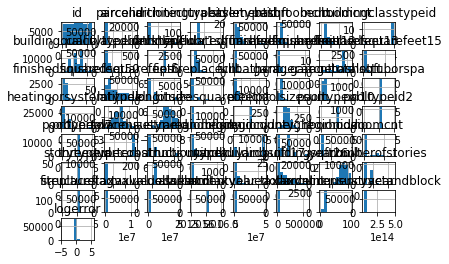

In [14]:
df.hist();


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77575 entries, 0 to 77574
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77575 non-null  int64  
 1   parcelid                      77575 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77575 non-null  float64
 6   bedroomcnt                    77575 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49809 non-null  float64
 9   calculatedbathnbr             76960 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6035 non-null   float64
 12  calculatedfinishedsquarefeet  77375 non-null  float64
 13  f

In [16]:
df.dtypes

id                            int64
parcelid                      int64
airconditioningtypeid       float64
architecturalstyletypeid    float64
basementsqft                float64
                             ...   
buildingclassdesc            object
heatingorsystemdesc          object
propertylandusedesc          object
storydesc                    object
typeconstructiondesc         object
Length: 68, dtype: object

In [17]:
shape1 = df.shape

In [18]:
# How many nulls have in each column?

df.isnull().sum()

id                              0
parcelid                        0
airconditioningtypeid       52569
architecturalstyletypeid    77369
basementsqft                77525
                            ...  
buildingclassdesc           77560
heatingorsystemdesc         28005
propertylandusedesc             0
storydesc                   77525
typeconstructiondesc        77353
Length: 68, dtype: int64

In [19]:
# % values missing in each column

df.isnull().sum()/len(df)*100

id                          0.00
parcelid                    0.00
airconditioningtypeid      67.77
architecturalstyletypeid   99.73
basementsqft               99.94
                            ... 
buildingclassdesc          99.98
heatingorsystemdesc        36.10
propertylandusedesc         0.00
storydesc                  99.94
typeconstructiondesc       99.71
Length: 68, dtype: float64

In [ ]:
# Percent complete rach column

complete = 100 - (df.isnull().sum()/len(df)*100)
complete

In [ ]:
# How many nulls have in each row?

df.isnull().sum(axis =1).value_counts()

In [ ]:
columns = df.columns.to_list()


In [ ]:
for col in columns:
    print(col.upper())
    print('\n')
    print(df[col].value_counts())
    print('\n')

3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values. 




<table>
<thead>
<tr>
<th></th>
<th align="right">num_rows_missing</th>
<th align="right">pct_rows_missing</th>
</tr>
</thead>
<tbody>
<tr>
<td>parcelid</td>
<td align="right">0</td>
<td align="right">0.000000</td>
</tr>
<tr>
<td>airconditioningtypeid</td>
<td align="right">29041</td>
<td align="right">0.535486</td>
</tr>
<tr>
<td>architecturalstyletypeid</td>
<td align="right">54232</td>
<td align="right">0.999982</td>
</tr>
</tbody>
</table>



In [ ]:
def describe_missing(df):
    columns = df.columns.to_list()
    num_rows_missing = []
    pct_rows_missing = []
    null_df = pd.DataFrame()
    for column in columns:
        num_rows_missing.append(df[column].isna().sum())
        pct_rows_missing.append(df[column].isna().sum()/df[column].shape[0]*100)
    null_df['attribute'] = columns
    null_df['num_rows_missing'] = num_rows_missing
    null_df['pct_rows_missing'] = pct_rows_missing
    return null_df

In [ ]:
describe_missing(df).sort_values(by=['pct_rows_missing'], ascending=False)


In [ ]:
missing = describe_missing(df).sort_values(by=['pct_rows_missing'], ascending=False)

In [ ]:
missing.head(51)

4. Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values. 




<table>
<thead>
<tr>
<th>num_cols_missing</th>
<th align="right">pct_cols_missing</th>
<th align="right">num_rows</th>
</tr>
</thead>
<tbody>
<tr>
<td>23</td>
<td align="right">38.333</td>
<td align="right">108</td>
</tr>
<tr>
<td>24</td>
<td align="right">40.000</td>
<td align="right">123</td>
</tr>
<tr>
<td>25</td>
<td align="right">41.667</td>
<td align="right">5280</td>
</tr>
</tbody>
</table>


In [ ]:
def missing_columns(df):
    columns = df.columns.to_list()
    nulls_by_row = []
    for i in range(df.shape[0]):
        nulls_by_row.append(df.iloc[i].isna().sum())
    df['null_count'] = nulls_by_row
    df['pct_col_missing'] = df.null_count / len(columns)
    df2 = df.pct_col_missing.value_counts().rename_axis('pct_col_missing').reset_index(name='num_rows')
    df3 = df.null_count.value_counts().rename_axis('num_cols_missing').reset_index(name='num_rows').drop(columns=['num_rows'])
    df = pd.concat([df3, df2], axis = 1)
    return df     

In [ ]:
missing_columns(df).sort_values(by=['num_cols_missing'], ascending=False)


<h4 id="prepare">Prepare</h4>
<ol>
<li>
<p>Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.  </p>




In [ ]:
df.propertylandusedesc.isna().sum()


In [ ]:
df.propertylandusedesc.value_counts()


In [ ]:
df = df[
    (df.propertylandusedesc == 'Single Family Residential')|
    (df.propertylandusedesc == 'Condominium')|
    (df.propertylandusedesc == 'Planned Unit Development')|
    (df.propertylandusedesc == 'Mobile Home')|
    (df.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes')|
    (df.propertylandusedesc == 'Residential General')
       ]

In [ ]:
shape2 = df.shape

In [ ]:
#rows_d = shape1[0]-shape2[0]
#columns_d = shape1[1]-shape2[1]

print(f'Original shape: {shape1}')
print(f'Current shape: {shape2}')
print(f'Rows dropped: {shape1[0]-shape2[0]}')
print(f'Columns dropped: {shape1[1]-shape2[1]}')

In [ ]:
df.calculatedfinishedsquarefeet.describe()


In [ ]:
# Removing rows where bedroomcnt == 0
df = df[df.bedroomcnt > 0]

In [ ]:
shape3 = df.shape
print(f'Original shape: {shape1}')
print(f'Last shape: {shape2}')
print(f'Current shape: {shape3}')
print()
print(f'Total Rows dropped: {shape1[0]-shape3[0]}')
print(f'Total Columns dropped: {shape1[1]-shape3[1]}')
print()
print(f'Rows dropped this step: {shape2[0]-shape3[0]}')
print(f'Columns dropped this step: {shape2[1]-shape3[1]}')

In [ ]:
# Removing rows where unitcnt is greater than 1
df = df[~(df.unitcnt > 1)]

In [ ]:
shape4 = df.shape
print(f'Original shape: {shape1}')
print(f'Last shape: {shape3}')
print(f'Current shape: {shape4}')
print()
print(f'Total Rows dropped: {shape1[0]-shape4[0]}')
print(f'Total Columns dropped: {shape1[1]-shape4[1]}')
print()
print(f'Rows dropped this step: {shape3[0]-shape4[0]}')
print(f'Columns dropped this step: {shape3[1]-shape4[1]}')

2. <p>Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).  </p>
<ul>
<li>The input:<ul>
<li>A dataframe</li>
<li>A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column.  i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).</li>
<li>A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing). </li>
</ul>
</li>
<li>The output:<ul>
<li>The dataframe with the columns and rows dropped as indicated. <em>Be sure to drop the columns prior to the rows in your function.</em></li>
</ul>
</li>
<li>hint:<ul>
<li>Look up the dropna documentation. </li>
<li>You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.</li>
<li>Make use of inplace, i.e. inplace=True/False.</li>
</ul>


In [ ]:
df.head()


In [ ]:
def handle_missing_values(df, prop_required_column = .5, prop_required_row = .75):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [ ]:
handle_missing_values(df)


In [ ]:
shape5 = df.shape
print(f'Original shape: {shape1}')
print(f'Last shape: {shape4}')
print(f'Current shape: {shape5}')
print()
print(f'Total Rows dropped: {shape1[0]-shape5[0]}')
print(f'Total Columns dropped: {shape1[1]-shape5[1]}')
print()
print(f'Rows dropped this step: {shape4[0]-shape5[0]}')
print(f'Columns dropped this step: {shape4[1]-shape5[1]}')

3. Decide how to handle the remaining missing values: </p>
<ul>
<li>Fill with constant value.</li>
<li>Impute with mean, median, mode.</li>
<li>Drop row/column</li>
</ul>
</li>
</ol>



In [ ]:
describe_missing(df).sort_values(by=['pct_rows_missing'], ascending=False).head(17)


In [ ]:
# Create a dictionary to reference later for the decision on each feature
null_plans = {}

In [ ]:
# Building type id
df.buildingqualitytypeid.describe()


In [ ]:
plt.hist(df.buildingqualitytypeid);


Tight sd around mean, roughly symmetrical, use mean

In [ ]:
null_plans['buildingqualitytypeid'] = 'mean'


In [ ]:
bath_bed_df = df[['bathroomcnt','bedroomcnt','calculatedbathnbr']] 
bath_bed_df

In [ ]:
bath_bed_df['diff']=bath_bed_df.bathroomcnt-bath_bed_df.calculatedbathnbr

In [ ]:
bath_bed_df.describe()

No difference between calculated bathroom bumber and bathroom count, can drop `calculatedbathnbr` column

In [ ]:
null_plans['calculatedbathnbr'] = 'drop'


In [ ]:
df.head()

In [ ]:
# Calculated SF

area_df = df[['calculatedfinishedsquarefeet','finishedsquarefeet12']] 
area_df['difference']=area_df.calculatedfinishedsquarefeet-area_df.finishedsquarefeet12
area_df.describe()

no difference between calculated and finished sf, drop calculatedsf columns

In [ ]:
null_plans['calculatedfinishedsquarefeet'] = 'drop'


In [ ]:
# Finished sf
plt.hist(df.finishedsquarefeet12, alpha=.7, histtype='step', label='finishedsquarefeet12');

---


<h4 id="wrangle_zillowpy">wrangle_zillow.py</h4>
<p>Functions of the work above needed to acquire and prepare a new sample of data. </p>


---


<h3 id="mall-customers">Mall Customers</h3>
<h4 id="notebook">notebook</h4>
<ol>
<li>Acquire data from mall_customers.customers in mysql database. </li>




2. Summarize data (include distributions and descriptive statistics).</li>



3. Detect outliers using IQR.</li>



4. Split data (train, validate, and test split).</li>



5. Encode categorical columns using a one hot encoder (pd.get_dummies).</li>



6. Handles missing values.</li>



7. Scaling</li>



---


</ol>
<h4 id="wrangle_mallpy">wrangle_mall.py</h4>



<ol>
<li>Acquire data from mall_customers.customers in mysql database. </li>



2. Split the data into train, validate, and split</li>


3. One-hot-encoding (pd.get_dummies)</li>



4. Missing values</li>



5. Scaling</li>
</ol>